Spawning PlanarRigidBodyVisualizer for tree with 4 actuators


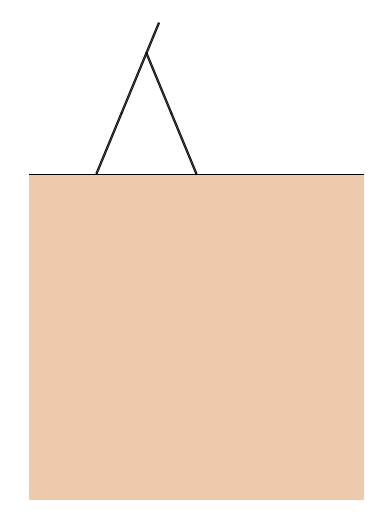

In [3]:
#%load_ext line_profiler

#%lprun -f __main__ __main__()
import math
import numpy as np

#from pydrake.all import (BasicVector, DiagramBuilder, FloatingBaseType,
                         #RigidBodyPlant, RigidBodyTree, Simulator,SignalLogger)

from pydrake.all import *
from underactuated import (FindResource, PlanarRigidBodyVisualizer)

from IPython.display import HTML


# Load the double pendulum from Universal Robot Description Format
#tree = RigidBodyTree(FindResource("double_pendulum/double_pendulum.urdf"), FloatingBaseType.kFixed)
#tree = RigidBodyTree(FindResource("../../notebooks/three_link.urdf"), FloatingBaseType.kFixed)
#tree = RigidBodyTree(FindResource("../../drake/examples/compass_gait/CompassGait.urdf"), FloatingBaseType.kFixed)



tree = RigidBodyTree(FindResource("../../notebooks/walkers/five_link.urdf"), FloatingBaseType.kFixed)

box_depth = 100

pi = math.pi

R = np.identity(3)
slope = 0
R[0, 0] = math.cos(slope)
R[0, 2] = math.sin(slope)
R[2, 0] = -math.sin(slope)
R[2, 2] = math.cos(slope)
X = Isometry3(rotation=R, translation=[0, 0, -5.])
                
color = np.array([0.9297, 0.7930, 0.6758, 1])
tree.world().AddVisualElement(VisualElement(Box([100., 1., 10.]), X, color))
tree.addCollisionElement(CollisionElement(Box([100., 1., 10.]), X), tree.world(), "the_ground")
tree.compile()


# Set up a block diagram with the robot (dynamics) and a visualization block.
builder = DiagramBuilder()
robot = builder.AddSystem(RigidBodyPlant(tree))

logger = builder.AddSystem(SignalLogger(robot.get_output_port(0).size()))
logger._DeclarePeriodicPublish(1. / 30., 0.0)

builder.Connect(robot.get_output_port(0), logger.get_input_port(0))
builder.ExportInput(robot.get_input_port(0)) #this allows the outside world to see push inputs in (or whatever)

diagram = builder.Build()

# Set up a simulator to run this diagram
simulator = Simulator(diagram)
#simulator.set_target_realtime_rate(1.0)
simulator.set_publish_every_time_step(False)

# Set the initial conditions
context = simulator.get_mutable_context()
#context.FixInputPort(0, BasicVector([0., 0., 0.]))  # Zero input torques
context.FixInputPort(0, BasicVector([0, 0, 0, 0]))  # Zero input torques

state = context.get_mutable_continuous_state_vector()
#state.SetFromVector((pi - pi/8, pi + pi/4 ,3*pi/2 - pi/4,0.,0.,0,))  # initial condition
#state.SetFromVector((  pi + pi/8, pi - pi/4  , 3*pi/2 - pi/4,0.,0.,0,0,0,0,0.))  # initial condition



#state.SetFromVector((pi + pi/8,  -pi/8 , pi/8 ,  ( pi/2 + pi/4) ,0, 0,0, 0,0,0))  # initial condition


initial_state = (pi - pi/8, 0 , pi/4 , 2*pi  -( pi/2 + pi/4) ,0, 0,0, 0,0,0)  # initial condition
final_state = (pi + pi/8,  0 , 0,  3*pi/4 ,0, 0 , 0, 0, 0, 0)  # final condition

#state.SetFromVector((pi,pi/2,0,0,0,0,0,0,0,0))  # initial condition
state.SetFromVector(initial_state)
# Simulate for 10 seconds
simulator.StepTo(.1)

prbv = PlanarRigidBodyVisualizer(tree, xlim=[-2.5, 2.5], ylim=[-5, 2.5])
ani = prbv.animate(logger, repeat=True)
#plt.close(prbv.fig)
HTML(ani.to_html5_video())



In [13]:
integrator = simulator.get_integrator()
integrator.set_target_accuracy(1e-3)

In [29]:

x_trajectory = PiecewisePolynomial.FirstOrderHold([0., 4.],
                                       np.column_stack((initial_state,
                                                        final_state)))

ani = prbv.animate(x_trajectory, resample=100, repeat=True)
HTML(ani.to_html5_video())


    